<a href="https://colab.research.google.com/github/Mongeese1/phyiscs-big-data/blob/master/Copy_of_Exoplanet_and_Light_curve_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#imports
# !pip install astroquery #downloading astroquery
%matplotlib inline
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.wcs import WCS
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import requests
import pandas as p
from IPython.display import display, HTML
import zipfile
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"

urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"
header={}


application/json; charset=UTF-8
Catalog 1: exoplanets.org
Catalog 2: nexsci
wasp-18 b  Properties
Stellar Mass 1.220000 M_sun
Planet Mass 10.200600 M_Jupiter
Planet Mass Reference: Calculated from MSINI and I
TIC: TIC 100100827
Planet Radius: 12.979840


TypeError: ignored

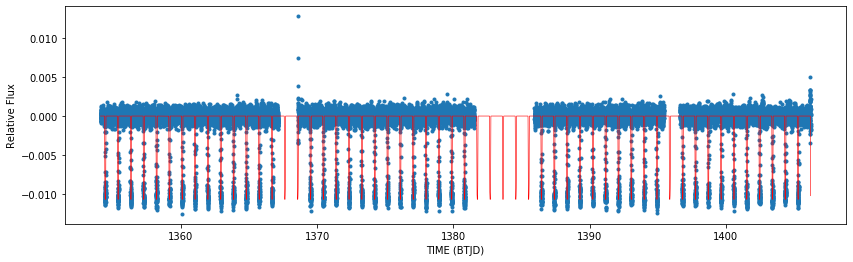

In [0]:
def GetLightCurve(name):
  planet_name = name

  url = planeturl + "/identifiers/"

  myparams = {"name":planet_name}

  r = requests.get(url = url, params = myparams, headers = header)
  print(r.headers.get('content-type'))

  planet_names = r.json()
  ticid = planet_names['tessID']
  tce = planet_names['tessTCE']
  planet_names


  url = planeturl + planet_name + "/properties/"

  r = requests.get(url = url, headers = header)

  planet_prop = r.json()

  print("Catalog 1: " + planet_prop[0]['catalog_name'])
  print("Catalog 2: " + planet_prop[1]['catalog_name'])
  planet_prop[0].keys()

  print(planet_name, " Properties")
  print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
  print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
  print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

  url = dvurl + str(ticid) + '/tces/'
  myparams = {"tce" : tce}

  r = requests.get(url = url, params = myparams, headers = header)
  sectorInfo = r.json()

  sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
  sectors
  #check whether in TESS catalogue
  try:
    sectors[0]
  except:
    print("Planet not in TESS catalogue")
    return

  url = dvurl + str(ticid) + '/info/'
  myparams = {"tce" : tce,
              "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  tceInfo = r.json()
  tceInfo.keys()
  tceInfo['DV Data Header'].keys()

  print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
  print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

  # Get The data
  url = dvurl + str(ticid) + '/table/'
  myparams = {"tce" : tce, "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)
  tce_data = r.json()

  data = p.DataFrame.from_dict(tce_data['data'])
  data.columns

  detrend = data['LC_DETREND']
  model = data['MODEL_INIT']
  time = data['TIME']

  plt.figure(figsize=(14,4))
  plt.plot(time,detrend,'.',lw=0.4)
  plt.plot(time,model,'r-',lw=0.6)
  plt.xlabel('TIME (BTJD)')
  plt.ylabel('Relative Flux')

  url = dvurl + str(ticid) + '/phaseplot/'
  myparams = {"tce" : tce, "sector" : sectors[0]}

  r = requests.get(url = url, params = myparams, headers = header)

  starName = "TIC" + str(ticid)
  radsearch = 3 / 60
  starData = Catalogs.query_object(starName, radius = radsearch, catalog = "TIC")
 
  Ra = starData[0]['ra']
  Dec = starData[0]['dec']

  # print( starData[:10]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )
  averageTmag = []
  lx = []
  for i in range(10):
    x = starData['Tmag'][i]
    # sus = np.sum(x, dtype=np.float64)
    averageTmag.append(x)
    for i in range(10):
      average = sum(averageTmag) / len(averageTmag)
  brightStar = starData['Tmag'] < average
  nearbyBrightStars = list( map( lambda x,y:[x,y], starData[brightStar]['ra'], starData[brightStar]['dec'] ) )
  print(len(nearbyBrightStars))
  
  urlStar = urlroot + "/sector"

  myparamsStar = {"ra":Ra, "dec":Dec, "radius":"0m"}

  requestDataStar = requests.get(url = urlStar, params = myparamsStar)
  sectors = requestDataStar.json()['results']
  print(sectors)
  myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px"}

  url = urlroot + "/astrocut"

  r = requests.get(url = url, params = myparams)

  print(r)
  print(r.headers.get('content-type'))

  open('astrocut.zip', 'wb').write(r.content)
  zipRef = zipfile.ZipFile('astrocut.zip','r')
  zipRef.extractall('.')
  zipRef.close()
  cutoutnames = zipRef.namelist()
  print(cutoutnames)
  files1 = cutoutnames[0]
  # fits.info(files1)
  imageData = fits.open(files1)
  image = imageData[1].data['Flux'][0]
  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(image, origin = 'lower', cmap = plt.cm.viridis, \
  #          vmax = np.percentile(image,95), vmin = np.percentile(image,2))
  
  wcs = WCS(imageData[2].header)

  fig = plt.figure(figsize = (10,10))
  fig.add_subplot(111, projection = wcs)
  plt.imshow(image, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(image,96),\
            vmin = np.percentile(image,10))

  plt.xlabel('CCD Column', fontsize = 14)
  plt.ylabel('CCD Row', fontsize = 14)
  plt.grid(axis = 'both', color = 'white', ls = 'solid')

  starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
  plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')

  # Plot nearby stars as well, which we created using our Catalog call above.
  nearbyLoc = wcs.all_world2pix(nearbyBrightStars[1:], 0)
  plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'orange')
  # print(requestDataStar.headers.get('content-type'))
  # print(brightStar)
  # display(HTML(str(r.content.decode('utf-8'))))
  # print(brightStar)
  # HAT-P-30 b

GetLightCurve("wasp-18 b")

In [0]:
GetLightCurve("HAT-P-30 b")